In [1]:
import torch
import cvxpy as cp
import numpy as np
from cvxpylayers.torch import CvxpyLayer
from scipy.linalg import sqrtm
from scipy.linalg import solve_discrete_are

torch.set_default_dtype(torch.double)

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
device = cuda0

torch.set_printoptions(precision=3)
torch.set_printoptions(sci_mode=False)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
print(torch.cuda.current_device())
torch.cuda.set_device(0)

True
1
NVIDIA RTX A2000 Laptop GPU
11.6
0


In [2]:
np.random.seed(1)

# generate problem data
n, m = 8, 2
noise = np.sqrt(.25)
u_max = .1
Q0 = np.eye(n)
R0 = np.eye(m)
A = np.random.randn(n, n)
A /= np.max(np.abs(np.linalg.eig(A)[0]))
B = np.random.randn(n, m)
W = noise**2 * np.eye(n)

In [12]:
# compute unconstrained lqr solution
P = cp.Variable((n, n), PSD=True)
R0cvxpy = cp.Parameter((m, m), PSD=True)

objective = cp.trace(P@W)
constraints = [cp.bmat([
    [R0cvxpy + B.T@P@B, B.T@P@A],
    [A.T@P@B, Q0+A.T@P@A-P]
]) >> 0, P >> 0]
R0cvxpy.value = R0
J_unconstrained_opt = cp.Problem(
    cp.Maximize(objective),
    constraints).solve()
P_unconstrained_opt = P.value
print("J_unconstrained_opt", J_unconstrained_opt)

J_unconstrained_opt 6.037566322322649


In [50]:
P_are = solve_discrete_are(A, B, Q0, R0)
np.testing.assert_allclose(P_are, P_unconstrained_opt, atol=1e-3)

In [4]:
# compute lower bound
P = cp.Variable((n, n), PSD=True)
R = cp.Variable((m, m), PSD=True)
lam = cp.Variable(m, nonneg=True)

objective = cp.trace(P@W) - (u_max**2)*cp.sum(lam)
constraints = [R - R0 << cp.diag(lam), P >> 0, R >> 0, lam >= 0]
constraints += [cp.bmat([
    [R + B.T@P@B, B.T@P@A],
    [A.T@P@B, Q0 + A.T@P@A-P]
]) >> 0]

j_lq_opt = cp.Problem(cp.Maximize(objective), constraints).solve()
print("lower bound j_lq_opt", j_lq_opt)

P_lq_opt = P.value
K_lq_opt = -np.linalg.solve(R0 + B.T @ P_lq_opt @ B, B.T @ P_lq_opt @ A)

lower bound j_lq_opt 10.702688100154873


In [10]:
Qt, Rt, At, Bt = map(torch.from_numpy, [Q0, R0, A, B])

Qt = Qt.to(device)
Rt = Rt.to(device)
At = At.to(device)
Bt = Bt.to(device)

def lb_loss(time_horizon, batch_size, K, seed=None):
    ''' Monte-Carlo \hat{J} for DARE-solution-based K: u = K x'''
    if seed is not None:
        torch.manual_seed(seed)
    x_batch = noise * torch.randn(batch_size, n, 1).double()
    K_batch = K.repeat(batch_size, 1, 1)
    Qt_batch = Qt.repeat(batch_size, 1, 1)
    Rt_batch = Rt.repeat(batch_size, 1, 1)
    At_batch = At.repeat(batch_size, 1, 1)
    Bt_batch = Bt.repeat(batch_size, 1, 1)
    
    x_batch = x_batch.to(device)
    K_batch = K_batch.to(device)
    Qt_batch = Qt_batch.to(device)
    Rt_batch = Rt_batch.to(device)
    At_batch = At_batch.to(device)
    Bt_batch = Bt_batch.to(device)

    loss = 0.0
    for _ in range(time_horizon):
        u_batch = torch.clamp(K @ x_batch, min=-u_max, max=u_max)
        state_cost = torch.bmm(torch.bmm(Qt_batch, x_batch).transpose(2, 1), x_batch)
        control_cost = torch.bmm(torch.bmm(Rt_batch, u_batch).transpose(2, 1), u_batch)
        cost_batch = (state_cost.squeeze() + control_cost.squeeze())
        loss += cost_batch.sum() / (time_horizon * batch_size)
        
        w = noise * torch.randn(batch_size, n, 1).double()
        w = w.to(device)
        
        x_batch = torch.bmm(At_batch, x_batch) + \
            torch.bmm(Bt_batch, u_batch) + w
            
    return loss

jhat_k_lq_opt = lb_loss(100, 6, torch.from_numpy(K_lq_opt).to(device), seed=0).item()

print("lower bound j_lq_opt", j_lq_opt)
print("monte-carlo for K_lq_opt", jhat_k_lq_opt)
print("we see that the lower bound j_lq_opt is NOT tight, no strong duality here")

lower bound j_lq_opt 10.702688100154873
monte-carlo for K_lq_opt 13.19278317731057
we see that the lower bound j_lq_opt is NOT tight, no strong duality here


In [13]:
# set up policy
x = cp.Parameter((n, 1))
P_sqrt = cp.Parameter((n, n))
q = cp.Parameter(n)

u = cp.Variable((m, 1))
xnext = cp.Variable((n, 1))

vclf_is_quadratic = cp.quad_form(u, R0) + cp.sum_squares(P_sqrt @ xnext) + q @ xnext
constraints = [
    xnext == A @ x + B @ u,
    cp.norm(u, "inf") <= u_max
]
controllyapunov_policy = CvxpyLayer(
    cp.Problem(
        cp.Minimize(vclf_is_quadratic),
        constraints
    ),
    [x, P_sqrt, q],
    [u]
)

def loss_controllyapunovpolicy(time_horizon, batch_size, P_sqrt, q, seed=None):
    ''' Monte-Carlo \hat{J} for control-lyapunov optimization solution: u = argmin'''
    ''' although we don't use the autodiff in cvxpylayers here'''
    ''' we are warm-starting the P parameter here with P_sqrt'''
    if seed is not None:
        torch.manual_seed(seed)
    x_batch = noise * torch.randn(batch_size, n, 1).double()
    P_sqrt_batch = P_sqrt.repeat(batch_size, 1, 1)
    q_batch = q.repeat(batch_size, 1)
    Qt_batch = Qt.repeat(batch_size, 1, 1)
    Rt_batch = Rt.repeat(batch_size, 1, 1)
    At_batch = At.repeat(batch_size, 1, 1)
    Bt_batch = Bt.repeat(batch_size, 1, 1)
    
    x_batch = x_batch.to(device)
    P_sqrt_batch = P_sqrt_batch.to(device)
    q_batch = q_batch.to(device)
    Qt_batch = Qt_batch.to(device)
    Rt_batch = Rt_batch.to(device)
    At_batch = At_batch.to(device)
    Bt_batch = Bt_batch.to(device)
    
    loss = 0.0
    for _ in range(time_horizon):
        u_batch, = controllyapunov_policy(
            x_batch,
            P_sqrt_batch,
            q_batch,
            solver_args={"acceleration_lookback": 0, "eps":1e-8, "max_iters":10000})
        
        state_cost = torch.bmm(torch.bmm(Qt_batch, x_batch).transpose(2, 1), x_batch)
        control_cost = torch.bmm(torch.bmm(Rt_batch, u_batch).transpose(2, 1), u_batch)
        cost_batch = (state_cost.squeeze() + control_cost.squeeze())
        loss += cost_batch.sum() / (time_horizon * batch_size)
        
        w = noise * torch.randn(batch_size, n, 1).double()
        w = w.to(device)

        x_batch = torch.bmm(At_batch, x_batch) + \
            torch.bmm(Bt_batch, u_batch) + w
    return loss

with torch.no_grad():
    clf_warmstart_unconstrained = loss_controllyapunovpolicy(100, 6,
        torch.from_numpy(sqrtm(P_unconstrained_opt)),
        torch.zeros(n, dtype=torch.double),
        seed=0).item()
    clf_warmstart_p_lq_opt = loss_controllyapunovpolicy(100, 6,
        torch.from_numpy(sqrtm(P_lq_opt)),
        torch.zeros(n, dtype=torch.double),
        seed=0).item()
print("clf_warmstart_unconstrained", clf_warmstart_unconstrained)

print("lower bound j_lq_opt", j_lq_opt)
print("monte-carlo for K_lq_opt, jhat_k_lq_opt", jhat_k_lq_opt)
print("clf_p_lq_opt", clf_warmstart_p_lq_opt)
print("we see that the lower bound j_lq_opt < clf_warmstart_p_lq_opt < jhat_k_lq_opt < clf_warmstart_unconstrained")

/usr/local/home/cyan3/miniforge/envs/tf/lib/python3.9/site-packages/diffcp/cone_program.py:296: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


clf_warmstart_unconstrained 16.92929399605388
lower bound j_lq_opt 10.702688100154873
monte-carlo for K_lq_opt, jhat_k_lq_opt 13.19278317731057
clf_p_lq_opt 12.887725560706565
we see that the lower bound j_lq_opt < clf_warmstart_p_lq_opt < jhat_k_lq_opt < clf_warmstart_unconstrained


In [18]:
# initialize parameters
def train(seed_start, P_sqrt, q):
#     torch.manual_seed(0)
#     P_sqrt = torch.from_numpy(sqrtm(P_lb)); P_sqrt.requires_grad_(True);
#     P_sqrt = torch.eye(n).double(); P_sqrt.requires_grad_(True);

#     q = torch.zeros(n).double(); q.requires_grad_(True);
    # q = torch.ones(n).double(); q.requires_grad_(True);
#     print("seed_start", seed_start)

    opt = torch.optim.SGD([P_sqrt, q], lr=.1)
    losses = []
    for k in range(60):
        with torch.no_grad():
            test_loss = loss_controllyapunovpolicy(100, 6, P_sqrt.detach(), q.detach(), seed=seed_start).item()
            losses.append(test_loss)
#             P_np = (P_sqrt.t() @ P_sqrt).detach().numpy()
#             dist = np.linalg.norm(P_np - P_lb)
            print("it: %03d, loss: %3.3f" % (k+1, test_loss))
        opt.zero_grad()
        l = loss_controllyapunovpolicy(100, 6, P_sqrt, q, seed=k+1)
        l.backward()
        opt.step()
        if k == 30:
            opt = torch.optim.SGD([P_sqrt, q], lr=.01)
            
    return losses

data = {}
s = 5
for i in np.linspace(-s, s, 2*s+1):
    print(i)
    
    P_lq_opt_tensor = i*torch.eye(n);
    q = i*torch.ones(n).double(); 
    
    P_lq_opt_tensor = P_lq_opt_tensor.to(device)
    q = q.to(device)
    
    P_lq_opt_tensor.requires_grad_(True);
    q.requires_grad_(True);
    
    losses2 = train(0, P_lq_opt_tensor, q)

    data[i] = {
        "losses" : losses2,
    }
    
P_lq_opt_tensor = torch.from_numpy(sqrtm(P_lq_opt))
P_lq_opt_tensor = P_lq_opt_tensor.to(device)
P_lq_opt_tensor.requires_grad_(True);
q = torch.ones(n).double(); q = q.to(device); q.requires_grad_(True);
losses1 = train(0, P_lq_opt_tensor, q)

-5.0
it: 001, loss: 14.337
it: 002, loss: 13.789
it: 003, loss: 13.162
it: 004, loss: 12.605
it: 005, loss: 12.216
it: 006, loss: 11.947
it: 007, loss: 11.811
it: 008, loss: 11.577
it: 009, loss: 11.428
it: 010, loss: 11.394
it: 011, loss: 11.438
it: 012, loss: 11.409
it: 013, loss: 11.471
it: 014, loss: 11.564
it: 015, loss: 11.621
it: 016, loss: 11.694
it: 017, loss: 11.973
it: 018, loss: 12.398
it: 019, loss: 12.582
it: 020, loss: 12.823
it: 021, loss: 12.972
it: 022, loss: 13.037
it: 023, loss: 13.321
it: 024, loss: 13.346
it: 025, loss: 13.398
it: 026, loss: 13.441
it: 027, loss: 13.487
it: 028, loss: 13.509
it: 029, loss: 13.536
it: 030, loss: 13.567
it: 031, loss: 13.716
it: 032, loss: 13.686
it: 033, loss: 13.685
it: 034, loss: 13.686
it: 035, loss: 13.686
it: 036, loss: 13.692
it: 037, loss: 13.690
it: 038, loss: 13.688
it: 039, loss: 13.689
it: 040, loss: 13.690
it: 041, loss: 13.690
it: 042, loss: 13.687
it: 043, loss: 13.687
it: 044, loss: 13.686
it: 045, loss: 13.686
it: 0

it: 012, loss: 13.491
it: 013, loss: 13.509
it: 014, loss: 13.448
it: 015, loss: 13.489
it: 016, loss: 13.456
it: 017, loss: 13.435
it: 018, loss: 13.439
it: 019, loss: 13.330
it: 020, loss: 13.501
it: 021, loss: 13.309
it: 022, loss: 13.374
it: 023, loss: 13.229
it: 024, loss: 13.165
it: 025, loss: 13.127
it: 026, loss: 13.150
it: 027, loss: 13.136
it: 028, loss: 13.141
it: 029, loss: 13.144
it: 030, loss: 13.196
it: 031, loss: 13.343
it: 032, loss: 13.452
it: 033, loss: 13.443
it: 034, loss: 13.431
it: 035, loss: 13.414
it: 036, loss: 13.413
it: 037, loss: 13.387
it: 038, loss: 13.359
it: 039, loss: 13.361
it: 040, loss: 13.347
it: 041, loss: 13.332
it: 042, loss: 13.334
it: 043, loss: 13.327
it: 044, loss: 13.314
it: 045, loss: 13.314
it: 046, loss: 13.308
it: 047, loss: 13.307
it: 048, loss: 13.295
it: 049, loss: 13.297
it: 050, loss: 13.289
it: 051, loss: 13.304
it: 052, loss: 13.282
it: 053, loss: 13.251
it: 054, loss: 13.253
it: 055, loss: 13.235
it: 056, loss: 13.223
it: 057, l

we see that the lower bound j_lq_opt < clf_warmstart_p_lq_opt < jhat_k_lq_opt < clf_warmstart_unconstrained


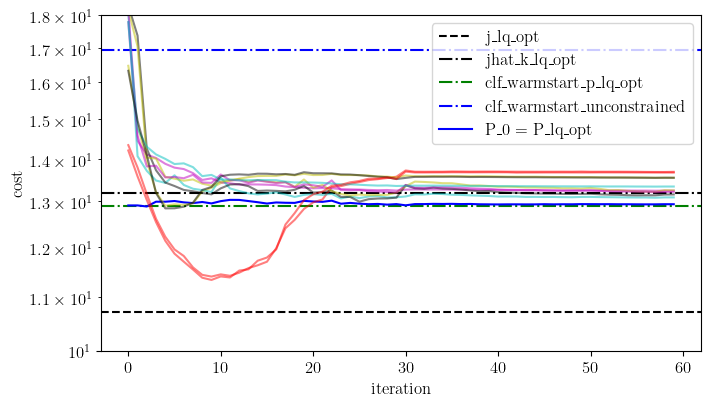

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
from utils import latexify

latexify(fig_width=8)
plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

print("we see that the lower bound j_lq_opt < clf_warmstart_p_lq_opt < jhat_k_lq_opt < clf_warmstart_unconstrained")
plt.axhline(j_lq_opt, linestyle='--', c='k', label='j_lq_opt')

plt.axhline(jhat_k_lq_opt, linestyle='-.', c='k', label='jhat_k_lq_opt')

plt.axhline(clf_warmstart_p_lq_opt, linestyle='-.', c='g', label='clf_warmstart_p_lq_opt')
plt.axhline(clf_warmstart_unconstrained, linestyle='-.', c='b', label='clf_warmstart_unconstrained')

plt.semilogy(losses1, c='b', label='P_0 = P_lq_opt')

colors = 'rymck'

all_keys = sorted(data.keys())
for s_i, s in enumerate(all_keys):
    plt.semilogy(data[s]["losses"], color=colors[s_i % len(colors)], alpha=0.5)

plt.xlabel('iteration')
plt.ylabel('cost')
plt.subplots_adjust(left=.15, bottom=.2)
plt.ylim(10, 18)
plt.legend(loc='upper right')
plt.savefig("lqr_constrained.jpg")
plt.show()

## Neural net

In [118]:
from torch import nn
from torch.nn import functional

class Net(nn.Module):
    def __init__(self, n, K):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, m)
        self.fc_K = nn.Linear(n, m, bias=False)
        self.fc_K.weight.data = K.data
#         for fc in [self.fc1, self.fc2, self.fc3]:
#             fc.weight.data.zero_()
#             fc.bias.data.zero_()

    def forward(self, x):
        u = self.fc_K(x) 
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = torch.clamp(self.fc3(x), -u_max, u_max)
        return x

In [124]:
policy = Net(n, torch.from_numpy(K_lqr))

In [125]:
def loss(time_horizon, batch_size, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    x_batch = noise * torch.randn(batch_size, n, 1).double()
    Qt_batch = Qt.repeat(batch_size, 1, 1)
    Rt_batch = Rt.repeat(batch_size, 1, 1)
    At_batch = At.repeat(batch_size, 1, 1)
    Bt_batch = Bt.repeat(batch_size, 1, 1)
    loss = 0.0
    for _ in range(time_horizon):
        u_batch = policy(x_batch.squeeze(-1))
        u_batch = u_batch.unsqueeze(-1)
        state_cost = torch.bmm(torch.bmm(Qt_batch, x_batch).transpose(2, 1), x_batch)
        control_cost = torch.bmm(torch.bmm(Rt_batch, u_batch).transpose(2, 1), u_batch)
        cost_batch = (state_cost.squeeze() + control_cost.squeeze())
        loss += cost_batch.sum() / (time_horizon * batch_size)
        x_batch = torch.bmm(At_batch, x_batch) + \
            torch.bmm(Bt_batch, u_batch) + \
            noise * torch.randn(batch_size, n, 1).double()
    return loss

In [128]:
opt = torch.optim.Adam(policy.parameters(), lr=3e-4)
losses = []
for k in range(10000):
    with torch.no_grad():
        test_loss = loss(100, 6, seed=0).item()
        losses.append(test_loss)
        print("it: %03d, loss: %3.3f" % (k+1, test_loss))
    opt.zero_grad()
    l = loss(100, 6, seed=k+1)
    l.backward()
    opt.step()
#     if k == 200:
#         opt = torch.optim.SGD(policy.parameters(), lr=1e-5)

it: 001, loss: 13.605
it: 002, loss: 13.605
it: 003, loss: 13.604
it: 004, loss: 13.596
it: 005, loss: 13.575
it: 006, loss: 13.551
it: 007, loss: 13.527
it: 008, loss: 13.505
it: 009, loss: 13.501
it: 010, loss: 13.491
it: 011, loss: 13.489
it: 012, loss: 13.482
it: 013, loss: 13.471
it: 014, loss: 13.464
it: 015, loss: 13.456
it: 016, loss: 13.448
it: 017, loss: 13.440
it: 018, loss: 13.431
it: 019, loss: 13.415
it: 020, loss: 13.397
it: 021, loss: 13.379
it: 022, loss: 13.360
it: 023, loss: 13.343
it: 024, loss: 13.330
it: 025, loss: 13.321
it: 026, loss: 13.313
it: 027, loss: 13.309
it: 028, loss: 13.304
it: 029, loss: 13.297
it: 030, loss: 13.293
it: 031, loss: 13.289
it: 032, loss: 13.283
it: 033, loss: 13.279
it: 034, loss: 13.275
it: 035, loss: 13.273
it: 036, loss: 13.275
it: 037, loss: 13.276
it: 038, loss: 13.279
it: 039, loss: 13.280
it: 040, loss: 13.280
it: 041, loss: 13.278
it: 042, loss: 13.278
it: 043, loss: 13.277
it: 044, loss: 13.276
it: 045, loss: 13.272
it: 046, l

KeyboardInterrupt: 

In [ ]:
plt.plot(losses)

## Piecewise quadratic

In [55]:
K = 25

In [56]:
# set up policy
x = cp.Parameter(n)
P_sqrt_cp = [cp.Parameter((n, n), PSD=True) for _ in range(K)]
q_cp = [cp.Parameter(n) for _ in range(K)]
r_cp = [cp.Parameter(1) for _ in range(K)]

u = cp.Variable(m)
xnext = cp.Variable(n)
t = cp.Variable(1)

objective = cp.quad_form(u, R0) + t
constraints = [xnext == A @ x + B @ u, cp.norm(u, "inf") <= u_max]
constraints += [cp.sum_squares(P_sqrt_cp[i] @ xnext) + q_cp[i] @ xnext + r_cp[i] <= t for i in range(K)]
prob = cp.Problem(cp.Minimize(objective), constraints)
policy = CvxpyLayer(prob, [x] + P_sqrt_cp + q_cp + r_cp, [u])

In [57]:
P_sqrt = [torch.from_numpy(sqrtm(P_lqr) + 1e-3*np.random.randn(n, n)) for _ in range(K)]
for i in range(K):
    P_sqrt[i].requires_grad_(True)
q = [torch.randn(n, requires_grad=True) for _ in range(K)]
r = [torch.zeros(1, requires_grad=True) for _ in range(K)]

In [58]:
def loss(time_horizon, batch_size, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    x_batch = noise * torch.randn(batch_size, n).double()
    Qt_batch = Qt.repeat(batch_size, 1, 1)
    Rt_batch = Rt.repeat(batch_size, 1, 1)
    At_batch = At.repeat(batch_size, 1, 1)
    Bt_batch = Bt.repeat(batch_size, 1, 1)
    loss = 0.0
    for _ in range(time_horizon):
        inputs = [x_batch] + P_sqrt + q + r
        u_batch, = policy(*inputs, solver_args={"acceleration_lookback": 0, "eps":1e-5, "max_iters":10000})
        state_cost = torch.bmm(torch.bmm(Qt_batch, x_batch.unsqueeze(-1)).transpose(2, 1), x_batch.unsqueeze(-1))
        control_cost = torch.bmm(torch.bmm(Rt_batch, u_batch.unsqueeze(-1)).transpose(2, 1), u_batch.unsqueeze(-1))
        cost_batch = (state_cost.squeeze() + control_cost.squeeze())
        loss += cost_batch.sum() / (time_horizon * batch_size)
        x_batch = torch.bmm(At_batch, x_batch.unsqueeze(-1)) + \
            torch.bmm(Bt_batch, u_batch.unsqueeze(-1)) + \
            noise * torch.randn(batch_size, n, 1).double()
        x_batch = x_batch.squeeze(-1)
    return loss

In [59]:
def norm(list_of_pytorch_tensors):
    with torch.no_grad():
        return torch.cat([t.view(-1) for t in list_of_pytorch_tensors]).norm().item()

In [63]:
params = P_sqrt + q + r
opt = torch.optim.SGD(params, lr=0.1)
losses = []
for k in range(100):
    with torch.no_grad():
        test_loss = loss(100, 6, seed=0).item()
        losses.append(test_loss)
        if params[0].grad is None:
            grad_norm = np.nan
        else:
            grad_norm = norm([p.grad.data for p in params])
        print("it: %03d, loss: %3.3f, grad_norm: %3.3f" % (k+1, test_loss, grad_norm))
    opt.zero_grad()
    l = loss(100, 6, seed=k+1)
    l.backward()
    torch.nn.utils.clip_grad_norm_(params, 10)
    opt.step()
    if k == 50:
        opt = torch.optim.SGD(params, lr=0.005)

it: 001, loss: 13.368, grad_norm: 0.000
it: 002, loss: 13.218, grad_norm: 2.971
it: 003, loss: 13.293, grad_norm: 2.776
it: 004, loss: 13.455, grad_norm: 5.518
it: 005, loss: 13.715, grad_norm: 3.672
it: 006, loss: 13.730, grad_norm: 3.191
it: 007, loss: 13.817, grad_norm: 3.788
it: 008, loss: 13.735, grad_norm: 4.652
it: 009, loss: 13.792, grad_norm: 4.192
it: 010, loss: 13.480, grad_norm: 4.183
it: 011, loss: 13.299, grad_norm: 6.466
it: 012, loss: 13.519, grad_norm: 3.917
it: 013, loss: 13.386, grad_norm: 4.412
it: 014, loss: 13.521, grad_norm: 2.561
it: 015, loss: 13.845, grad_norm: 3.820
it: 016, loss: 13.671, grad_norm: 1.890
it: 017, loss: 13.580, grad_norm: 2.818
it: 018, loss: 13.508, grad_norm: 6.822
it: 019, loss: 13.659, grad_norm: 8.734
it: 020, loss: 13.598, grad_norm: 3.174
it: 021, loss: 13.446, grad_norm: 4.614
it: 022, loss: 13.518, grad_norm: 4.279
it: 023, loss: 13.473, grad_norm: 5.674
it: 024, loss: 13.466, grad_norm: 3.205
it: 025, loss: 13.397, grad_norm: 4.298


NameError: name 'param' is not defined